In [1]:
import pandas as pd
import glob
from pathlib import Path
import json
import numpy as np

In [2]:
## Evaluating generation

In [3]:
# 1. load corpora
# 2. run TextGenerationEvaluator

In [4]:
## Rest

In [5]:
import json
import pickle

with open("/home/kuba/Projects/github_search/.dagster/storage/generation_metrics_df", "rb") as f:
    generation_metrics_df = pickle.load(f)


with open("/home/kuba/Projects/github_search/.dagster/storage/per_query_generation_metrics_df", "rb") as f:
    per_query_generation_metrics_df = pickle.load(f)

In [6]:

with open("/home/kuba/Projects/github_search/.dagster/storage/repos_with_representations_df", "rb") as f:
    repos_with_representations_df = pickle.load(f)

In [7]:
repos_with_representations_df.columns

Index(['repo', 'generated_tasks', 'generated_tasks_raw',
       'dependency_signature', 'paper_urls', 'paper_titles', 'titles',
       'arxiv_ids', 'authors', 'tasks', 'readme', 'query_tasks', 'repomap',
       'repository_signature'],
      dtype='object')

In [8]:
#def process_generation_metrics_df(generation_metrics_df):
#    return (
#        generation_metrics_df.assign(
#            true_tasks=generation_metrics_df["true_tasks"].str.split(", ").apply(tuple)
#        ).groupby(["repo", "true_tasks"]).apply(lambda df: df.select_dtypes("float").mean())
#    )["code2doc_generated_readme", "code2doc_reasoning", "code2doc_generation_context"]

In [9]:
colorcodings = {
    "generated_tasks": "red", "repository_signature": "red", "dependency_signature": "red",
    "selected_code": "orange",
    "code2doc_generated_readme":"green", "code2doc_generation_context": "green", "code2doc_reasoning": "green",
    "generated_readme (repomap)":"cyan", "generation_context (repomap)": "cyan", "generated_rationale (repomap)": "cyan"}

def format_corpus_for_latex(corpus_name, intensity=25):
    
    if colorcodings.get(corpus_name) is None:
        return corpus_name
    else:
        color = colorcodings[corpus_name]
        corpus_name = corpus_name.replace("generation_context", "code summary")
        return f"{{\color{{{color}}} {corpus_name}}}"


def format_retriever_for_latex(retriever_name, intensity=25):
    if retriever_name == "bm25":
        retriever_name = f"{{\color{{blue}} {retriever_name}}}"
    elif retriever_name == "all-mpnet-base-v2 (sentence_transformer)":
        retriever_name = "st-MPNet"
    elif retriever_name == "all-MiniLM-L12-v2 (sentence_transformer)":
        retriever_name = "st-MiniLM"
    elif retriever_name == "Word2Vec":
        retriever_name = f"{{\color{{violet}} {retriever_name}}}"
    else:
        pass
    return retriever_name.replace("_", " ")

<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_7612/1388725134.py:14: SyntaxWarning: invalid escape sequence '\c'
  return f"{{\color{{{color}}} {corpus_name}}}"
/tmp/ipykernel_7612/1388725134.py:19: SyntaxWarning: invalid escape sequence '\c'
  retriever_name = f"{{\color{{blue}} {retriever_name}}}"
/tmp/ipykernel_7612/1388725134.py:25: SyntaxWarning: invalid escape sequence '\c'
  retriever_name = f"{{\color{{violet}} {retriever_name}}}"


In [10]:
#generation_metrics_df = process_generation_metrics_df(generation_metrics_df)

In [11]:
#generation_metrics_df = generation_metrics_df.reset_index()

In [12]:
#raw_ir_metrics_df = pd.read_csv("../output/code2doc/sample_per_task_5_repos/beir_results_codellama.csv")
raw_ir_metrics_df = pd.read_csv("../results/per_query_ir_results.csv")

In [13]:
raw_ir_metrics_df.columns

Index(['query', 'retriever', 'corpus', 'Hits@1', 'Hits@5', 'Hits@10',
       'Hits@25', 'Accuracy@1', 'Precision@1', 'Accuracy@5', 'Precision@5',
       'Accuracy@10', 'Precision@10', 'Accuracy@25', 'Precision@25'],
      dtype='object')

In [14]:
merged_metrics_df = raw_ir_metrics_df.merge(per_query_generation_metrics_df, left_on="query", right_on="task")

In [15]:
merged_metrics_df.select_dtypes("float").corr()[["Accuracy@10", "Precision@10"]].loc[["rougeL", "sentence_transformer_similarity"]]

,Accuracy@10,Precision@10
rougeL,0.168705,0.214398
sentence_transformer_similarity,0.121441,0.139646


In [100]:
repomap_ir_metrics_df = pd.read_csv("../output/code2doc/sample_per_task_5_repos/beir_results_codellama_repomaps.csv")
repomap_ir_metrics_df = repomap_ir_metrics_df[repomap_ir_metrics_df["corpus"].isin(["generated_readme", "generation_context", "generated_rationale"])]
repomap_ir_metrics_df["corpus"] = repomap_ir_metrics_df["corpus"] + " (repomap)"

In [118]:
raw_ir_metrics_df

,query,retriever,corpus,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
0,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
1,2d human pose estimation,bm25,code2doc_generation_context,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
2,2d human pose estimation,bm25,code2doc_reasoning,0.0,1.0,2.0,5.0,0.0,0.0,1.0,0.2,1.0,0.2,1.0,0.20
3,2d human pose estimation,bm25,dependency_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2d human pose estimation,bm25,generated_tasks,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23771,zero shot learning,word2vec,dependency_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
23772,zero shot learning,word2vec,generated_tasks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
23773,zero shot learning,word2vec,readme,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,0.1,1.0,0.04
23774,zero shot learning,word2vec,repository_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


,corpus,retriever,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
0,code2doc_generated_readme,bm25,0.503383,1.798376,2.792963,4.477673,0.503383,0.503383,0.760487,0.359675,0.837618,0.279296,0.897158,0.179107
1,code2doc_generated_readme,sentence-transformers/all-MiniLM-L12-v2,0.519515,2.002692,3.157470,5.047106,0.519515,0.519515,0.802153,0.400538,0.862719,0.315747,0.920592,0.201884
2,code2doc_generated_readme,sentence-transformers/all-mpnet-base-v2,0.520861,2.010767,3.215343,5.327052,0.520861,0.520861,0.792732,0.402153,0.855989,0.321534,0.916555,0.213082
3,code2doc_generated_readme,word2vec,0.197847,0.772544,1.242261,2.309556,0.197847,0.197847,0.465680,0.154509,0.584118,0.124226,0.736205,0.092382
4,code2doc_generation_context,bm25,0.461538,1.628880,2.476383,3.931174,0.461538,0.461538,0.734143,0.325776,0.807018,0.247638,0.882591,0.157247
5,code2doc_generation_context,sentence-transformers/all-MiniLM-L12-v2,0.417227,1.438762,2.230148,3.570659,0.417227,0.417227,0.694482,0.287752,0.788694,0.223015,0.873486,0.142826
6,code2doc_generation_context,sentence-transformers/all-mpnet-base-v2,0.442799,1.623149,2.499327,4.069987,0.442799,0.442799,0.729475,0.324630,0.791386,0.249933,0.885599,0.162799
7,code2doc_generation_context,word2vec,0.123822,0.477793,0.783311,1.496635,0.123822,0.123822,0.321669,0.095559,0.442799,0.078331,0.601615,0.059865
8,code2doc_reasoning,bm25,0.500675,1.757085,2.728745,4.363023,0.500675,0.500675,0.763833,0.351417,0.836707,0.272874,0.889339,0.174521
9,code2doc_reasoning,sentence-transformers/all-MiniLM-L12-v2,0.522207,1.868102,2.952894,4.736205,0.522207,0.522207,0.772544,0.373620,0.845222,0.295289,0.908479,0.189448


In [184]:
ir_metrics_df = raw_ir_metrics_df.drop(columns=["query"]).groupby(["corpus", "retriever"]).agg("mean").reset_index()
#    raw_ir_metrics_df,
#    repomap_ir_metrics_df])

#ir_metrics_df = ir_metrics_df[ir_metrics_df["retriever"] != "splade"]
#ir_metrics_df = ir_metrics_df.assign(
#    retriever=ir_metrics_df["retriever"].apply(format_retriever_for_latex),
#    corpus=ir_metrics_df["corpus"].apply(format_corpus_for_latex)
#)

In [325]:
def convert_df_to_latex_table(df, cols=["corpus", "retriever", "Accuracy@10", "Precision@10"], sort_values="Accuracy@10", column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|"):
    df = df.copy()
    if "retriever" in cols:
        df["retriever"] = df["retriever"].apply(format_retriever_for_latex)
    df["corpus"] = df["corpus"].apply(format_corpus_for_latex)
    return (
        df[
            cols
        ].sort_values(sort_values, ascending=False)
        .to_latex(index_names=False, index=False, column_format=column_format, float_format="%.3f")
        .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
    )

<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_638412/3317013727.py:11: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
/tmp/ipykernel_638412/3317013727.py:11: SyntaxWarning: invalid escape sequence '\h'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")


In [326]:
ir_metrics_best_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop_duplicates(subset=["corpus"])

In [327]:
basic_corpora = ["readme", "dependency_signature", "selected_code"]
basic_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora)]

## Basic corpora

In [328]:
basic_ir_metrics_best_retriever_df

,corpus,retriever,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
22,readme,sentence-transformers/all-mpnet-base-v2,0.643338,2.562584,4.257066,6.919246,0.643338,0.643338,0.877524,0.512517,0.928668,0.425707,0.959623,0.276770
28,selected_code,bm25,0.373478,1.190798,1.813261,2.871448,0.373478,0.373478,0.599459,0.238160,0.684709,0.181326,0.787551,0.114858
14,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.047106,0.181696,0.263795,0.438762,0.047106,0.047106,0.153432,0.036339,0.197847,0.026380,0.304172,0.017550


In [329]:
print(convert_df_to_latex_table(basic_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Precision@10 \\
\hline
\midrule
\hline
readme & sentence-transformers/all-mpnet-base-v2 & 0.929 & 0.426 \\
\hline
{\color{orange} selected code} & {\color{blue} bm25} & 0.685 & 0.181 \\
\hline
{\color{red} dependency signature} & sentence-transformers/all-mpnet-base-v2 & 0.198 & 0.026 \\
\hline
\bottomrule
\hline
\end{tabular}


## Signature corpora

In [330]:
signature_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora + ["repository_signature", "generated_tasks"])]

In [331]:
print(convert_df_to_latex_table(signature_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Precision@10 \\
\hline
\midrule
\hline
readme & sentence-transformers/all-mpnet-base-v2 & 0.929 & 0.426 \\
\hline
{\color{orange} selected code} & {\color{blue} bm25} & 0.685 & 0.181 \\
\hline
{\color{red} generated tasks} & sentence-transformers/all-MiniLM-L12-v2 & 0.280 & 0.038 \\
\hline
{\color{red} repository signature} & sentence-transformers/all-mpnet-base-v2 & 0.240 & 0.032 \\
\hline
{\color{red} dependency signature} & sentence-transformers/all-mpnet-base-v2 & 0.198 & 0.026 \\
\hline
\bottomrule
\hline
\end{tabular}


## Code2doc 

In [332]:
code2doc_corpora = ["readme"]
for cname in ["code2doc_generated_readme", "code2doc_reasoning", "code2doc_generation_context"]:
    code2doc_corpora.append(cname)
    code2doc_corpora.append(cname + " (repomap)")

code2doc_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(code2doc_corpora)]

In [333]:
code2doc_ir_metrics_best_retriever_df

,corpus,retriever,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
22,readme,sentence-transformers/all-mpnet-base-v2,0.643338,2.562584,4.257066,6.919246,0.643338,0.643338,0.877524,0.512517,0.928668,0.425707,0.959623,0.276770
2,code2doc_generated_readme,sentence-transformers/all-mpnet-base-v2,0.520861,2.010767,3.215343,5.327052,0.520861,0.520861,0.792732,0.402153,0.855989,0.321534,0.916555,0.213082
10,code2doc_reasoning,sentence-transformers/all-mpnet-base-v2,0.523553,1.955585,3.061911,4.977120,0.523553,0.523553,0.783311,0.391117,0.846568,0.306191,0.912517,0.199085
6,code2doc_generation_context,sentence-transformers/all-mpnet-base-v2,0.442799,1.623149,2.499327,4.069987,0.442799,0.442799,0.729475,0.324630,0.791386,0.249933,0.885599,0.162799


In [334]:
print(convert_df_to_latex_table(code2doc_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Precision@10 \\
\hline
\midrule
\hline
readme & sentence-transformers/all-mpnet-base-v2 & 0.929 & 0.426 \\
\hline
{\color{green} code2doc generated readme} & sentence-transformers/all-mpnet-base-v2 & 0.856 & 0.322 \\
\hline
{\color{green} code2doc reasoning} & sentence-transformers/all-mpnet-base-v2 & 0.847 & 0.306 \\
\hline
{\color{green} code2doc code summary} & sentence-transformers/all-mpnet-base-v2 & 0.791 & 0.250 \\
\hline
\bottomrule
\hline
\end{tabular}


## Best retriever

In [336]:
print(convert_df_to_latex_table(ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Precision@10 \\
\hline
\midrule
\hline
readme & sentence-transformers/all-mpnet-base-v2 & 0.929 & 0.426 \\
\hline
{\color{green} code2doc generated readme} & sentence-transformers/all-mpnet-base-v2 & 0.856 & 0.322 \\
\hline
{\color{green} code2doc reasoning} & sentence-transformers/all-mpnet-base-v2 & 0.847 & 0.306 \\
\hline
{\color{green} code2doc code summary} & sentence-transformers/all-mpnet-base-v2 & 0.791 & 0.250 \\
\hline
{\color{orange} selected code} & {\color{blue} bm25} & 0.685 & 0.181 \\
\hline
{\color{red} generated tasks} & sentence-transformers/all-MiniLM-L12-v2 & 0.280 & 0.038 \\
\hline
{\color{red} repository signature} & sentence-transformers/all-mpnet-base-v2 & 0.240 & 0.032 \\
\hline
{\color{red} dependency signature} & sentence-transformers/all-mpnet-base-v2 & 0.198 & 0.026 \\
\hline
\bottomrule
\hline
\end{tabular}


## Average over retrievers

In [282]:
ir_metrics_avg_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop(columns=["retriever"]).groupby("corpus").agg("mean").reset_index()

In [338]:
print(convert_df_to_latex_table(ir_metrics_avg_retriever_df,  cols=["corpus", "Accuracy@10", "Precision@10"], sort_values="Precision@10", column_format="|p{3cm}|p{2cm}|p{2cm}|"))

\begin{tabular}{|p{3cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & Accuracy@10 & Precision@10 \\
\hline
\midrule
\hline
readme & 0.837 & 0.343 \\
\hline
{\color{green} code2doc generated readme} & 0.785 & 0.260 \\
\hline
{\color{green} code2doc reasoning} & 0.769 & 0.248 \\
\hline
{\color{green} code2doc code summary} & 0.707 & 0.200 \\
\hline
{\color{orange} selected code} & 0.562 & 0.132 \\
\hline
{\color{red} generated tasks} & 0.252 & 0.034 \\
\hline
{\color{red} repository signature} & 0.205 & 0.026 \\
\hline
{\color{red} dependency signature} & 0.151 & 0.019 \\
\hline
\bottomrule
\hline
\end{tabular}


In [284]:
per_query_metrics_df = raw_ir_metrics_df
per_query_metrics_df.columns = [c.lower() for c in per_query_metrics_df.columns]

In [285]:
per_query_metrics_df

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,precision@1,accuracy@5,precision@5,accuracy@10,precision@10,accuracy@25,precision@25
0,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
1,2d human pose estimation,bm25,code2doc_generation_context,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
2,2d human pose estimation,bm25,code2doc_reasoning,0.0,1.0,2.0,5.0,0.0,0.0,1.0,0.2,1.0,0.2,1.0,0.20
3,2d human pose estimation,bm25,dependency_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2d human pose estimation,bm25,generated_tasks,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23771,zero shot learning,word2vec,dependency_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
23772,zero shot learning,word2vec,generated_tasks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
23773,zero shot learning,word2vec,readme,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,0.1,1.0,0.04
23774,zero shot learning,word2vec,repository_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [286]:
generation_metrics_df["task"].explode().value_counts()

task
general classification                   357
reinforcement learning                   331
semantic segmentation                    311
translation                              285
object detection                         272
                                        ... 
blind image deblurring                     1
interactive video object segmentation      1
action understanding                       1
stereo disparity estimation                1
hyperspectral image super resolution       1
Name: count, Length: 1173, dtype: int64

In [287]:
#generation_metrics_df["true_tasks"] = generation_metrics_df["true_tasks"].str.replace("'", '"').apply(json.loads)

In [288]:
generation_metrics_df

,repo,task,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
0,008karan/SincNet_demo,"[speaker recognition, speaker identification, ...",0.363636,0.222222,0.363636,0.363636,0.723902
1,011235813/cm3,"[efficient exploration, autonomous vehicles, m...",0.666667,0.625000,0.666667,0.666667,0.723890
2,011235813/hierarchical-marl,"[q learning, multi agent reinforcement learnin...",0.800000,0.615385,0.800000,0.800000,0.841959
3,011235813/lio,[general reinforcement learning],0.363636,0.222222,0.363636,0.363636,0.555174
4,0411tony/Yue,[recommendation systems],0.250000,0.000000,0.250000,0.250000,0.626208
...,...,...,...,...,...,...,...
6775,zwx8981/DBCNN-PyTorch,"[image quality assessment, blind image quality...",0.500000,0.428571,0.500000,0.500000,0.822270
6776,zwx8981/UNIQUE,"[image quality assessment, blind image quality...",0.000000,0.000000,0.000000,0.000000,0.417615
6777,zxleong/GPRNet,"[semantic segmentation, seismic imaging, gpr, ...",0.000000,0.000000,0.000000,0.000000,0.416624
6778,zychen423/KE-VIST,"[visual storytelling, knowledge graphs, story ...",0.117647,0.000000,0.117647,0.117647,0.527462


In [289]:
generation_metrics_df

,repo,task,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
0,008karan/SincNet_demo,"[speaker recognition, speaker identification, ...",0.363636,0.222222,0.363636,0.363636,0.723902
1,011235813/cm3,"[efficient exploration, autonomous vehicles, m...",0.666667,0.625000,0.666667,0.666667,0.723890
2,011235813/hierarchical-marl,"[q learning, multi agent reinforcement learnin...",0.800000,0.615385,0.800000,0.800000,0.841959
3,011235813/lio,[general reinforcement learning],0.363636,0.222222,0.363636,0.363636,0.555174
4,0411tony/Yue,[recommendation systems],0.250000,0.000000,0.250000,0.250000,0.626208
...,...,...,...,...,...,...,...
6775,zwx8981/DBCNN-PyTorch,"[image quality assessment, blind image quality...",0.500000,0.428571,0.500000,0.500000,0.822270
6776,zwx8981/UNIQUE,"[image quality assessment, blind image quality...",0.000000,0.000000,0.000000,0.000000,0.417615
6777,zxleong/GPRNet,"[semantic segmentation, seismic imaging, gpr, ...",0.000000,0.000000,0.000000,0.000000,0.416624
6778,zychen423/KE-VIST,"[visual storytelling, knowledge graphs, story ...",0.117647,0.000000,0.117647,0.117647,0.527462


In [290]:
generation_metric_names = [
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'sentence_transformer_similarity',
 'wmd']

In [291]:
per_query_metrics_df.head()

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,precision@1,accuracy@5,precision@5,accuracy@10,precision@10,accuracy@25,precision@25
0,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
1,2d human pose estimation,bm25,code2doc_generation_context,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
2,2d human pose estimation,bm25,code2doc_reasoning,0.0,1.0,2.0,5.0,0.0,0.0,1.0,0.2,1.0,0.2,1.0,0.20
3,2d human pose estimation,bm25,dependency_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2d human pose estimation,bm25,generated_tasks,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04


In [292]:
per_query_generation_metrics_df.shape

(1173, 5)

In [293]:
retriever_name = "bm25"
corpus_name = "readme"


In [294]:
per_query_metrics_df["retriever"].unique()

array(['bm25', 'sentence-transformers/all-MiniLM-L12-v2',
       'sentence-transformers/all-mpnet-base-v2', 'word2vec'],
      dtype=object)

In [346]:
checked_corpora = [
       'dependency_signature', 'repository_signature', 'generated_tasks'
] + ["code2doc_generated_readme", "code2doc_reasoning", "code2doc_generation_context"]

checked_retrievers = ['bm25', 'sentence-transformers/all-mpnet-base-v2',
       'sentence-transformers/all-MiniLM-L12-v2',
       #'flax-sentence-embeddings/st-codesearch-distilroberta-base'
]


In [347]:
import seaborn as sns
import matplotlib.pyplot as plt

In [348]:
shown_generation_metrics = ["rougeL"]#, "sentence_transformer_similarity"]


def get_worst_queries(df, q=0.1, metrics=shown_generation_metrics):
    is_lowest = (df[metrics] < df[metrics].quantile(q)).min(axis=1) > 0
    return df[is_lowest].index

In [349]:
worst_queries = get_worst_queries(per_query_generation_metrics_df, q=0.1)

In [350]:
len(worst_queries)

118

In [351]:
per_query_generation_metrics_df["rougeL"].quantile(0.2)

0.1288888333888334

In [352]:
per_query_metrics_df["query"]

0        2d human pose estimation
1        2d human pose estimation
2        2d human pose estimation
3        2d human pose estimation
4        2d human pose estimation
                   ...           
23771          zero shot learning
23772          zero shot learning
23773          zero shot learning
23774          zero shot learning
23775          zero shot learning
Name: query, Length: 23776, dtype: object

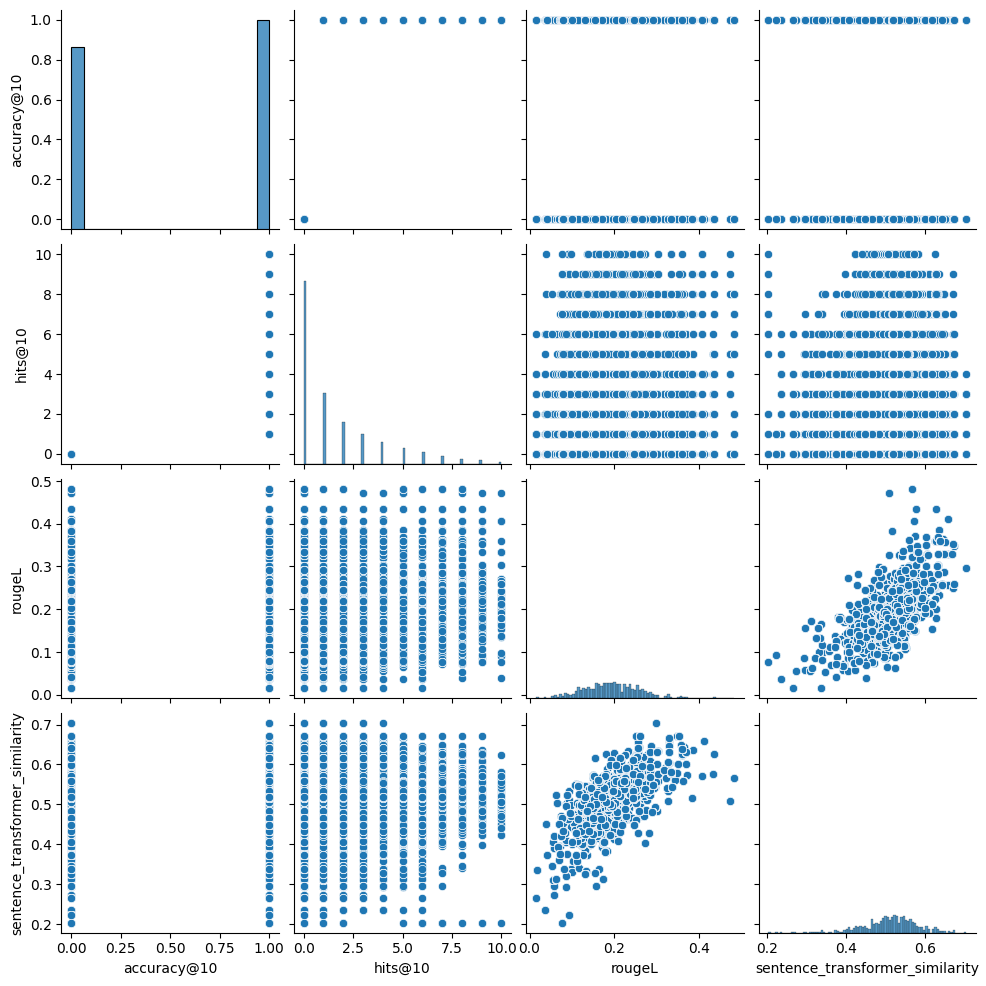

In [353]:
sns.pairplot(per_query_metrics_df.merge(per_query_generation_metrics_df, left_on="query", right_index=True)[["accuracy@10", "hits@10", "rougeL", "sentence_transformer_similarity"]])

In [354]:
worst_queries.shape

(118,)

dependency_signature bm25


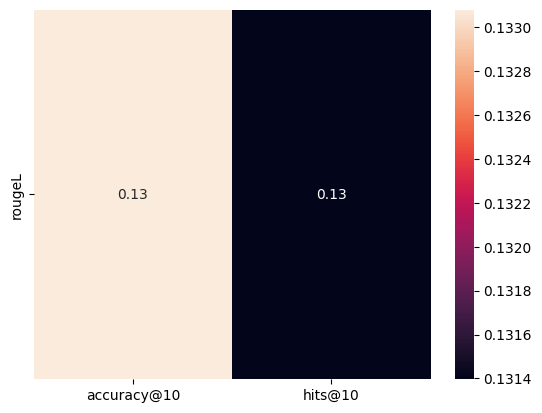

dependency_signature sentence-transformers/all-mpnet-base-v2


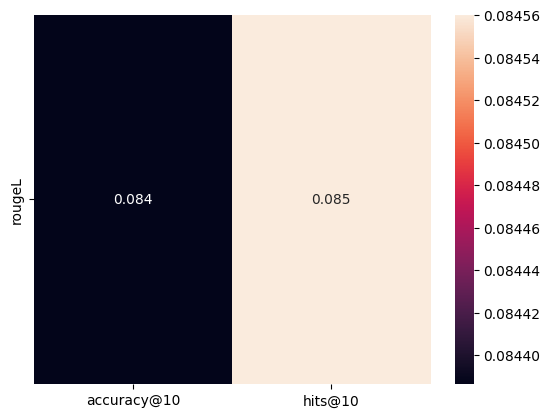

dependency_signature sentence-transformers/all-MiniLM-L12-v2


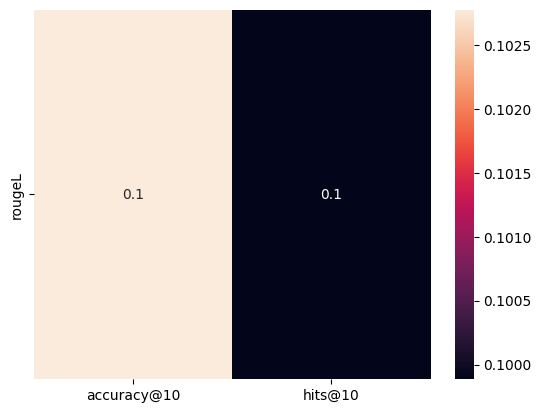

repository_signature bm25


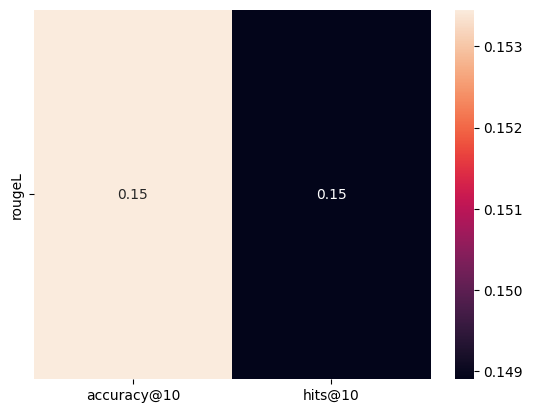

repository_signature sentence-transformers/all-mpnet-base-v2


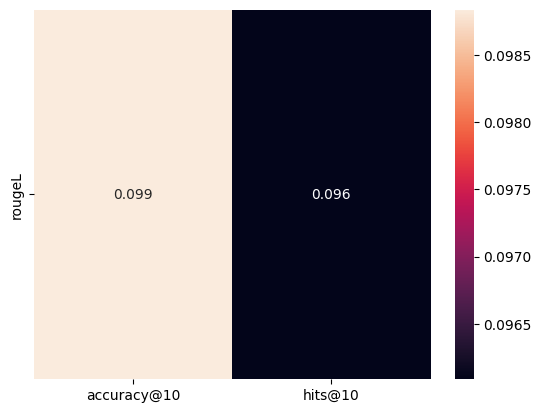

repository_signature sentence-transformers/all-MiniLM-L12-v2


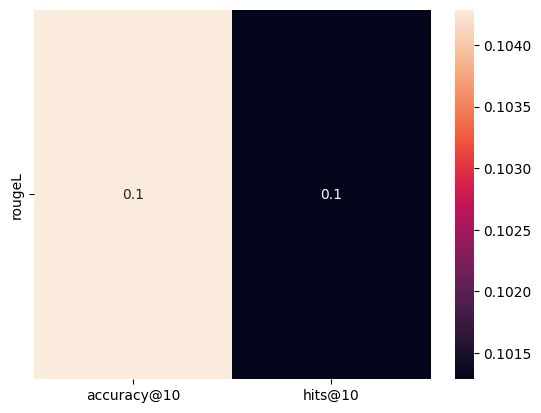

generated_tasks bm25


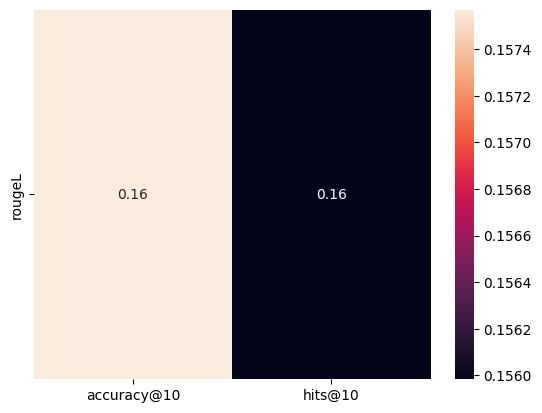

generated_tasks sentence-transformers/all-mpnet-base-v2


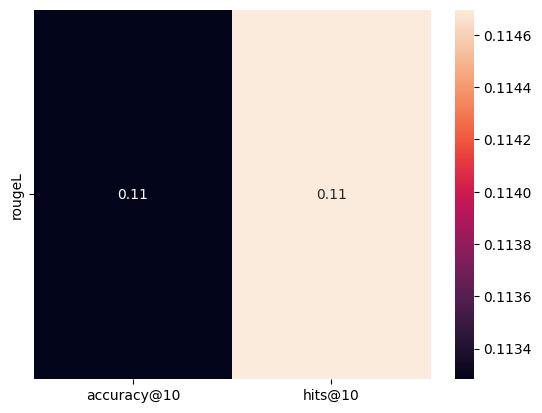

generated_tasks sentence-transformers/all-MiniLM-L12-v2


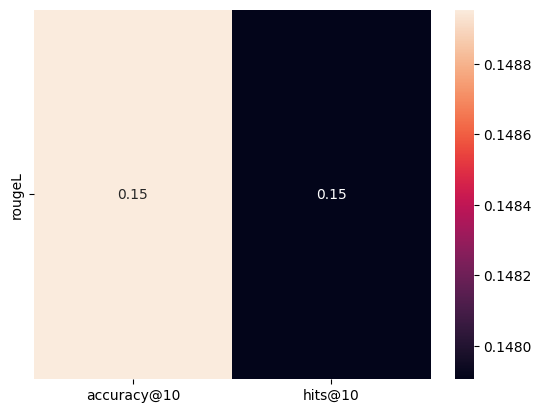

code2doc_generated_readme bm25


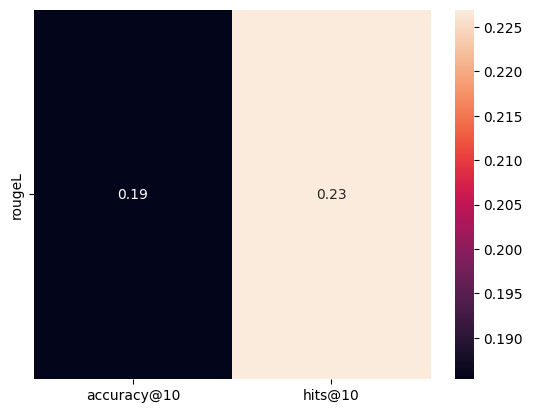

code2doc_generated_readme sentence-transformers/all-mpnet-base-v2


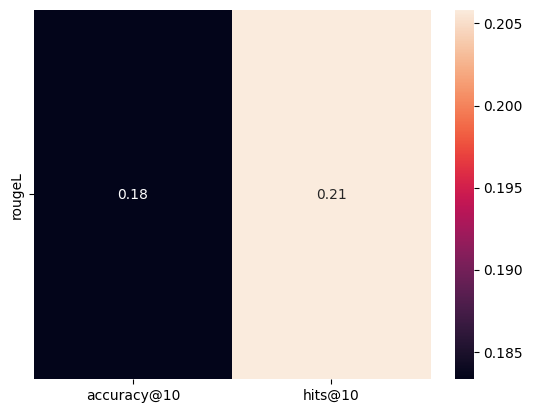

code2doc_generated_readme sentence-transformers/all-MiniLM-L12-v2


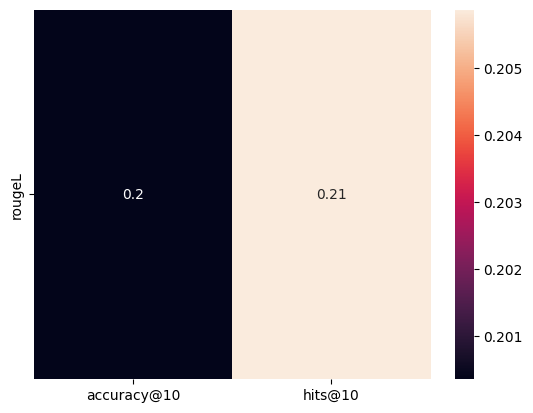

code2doc_reasoning bm25


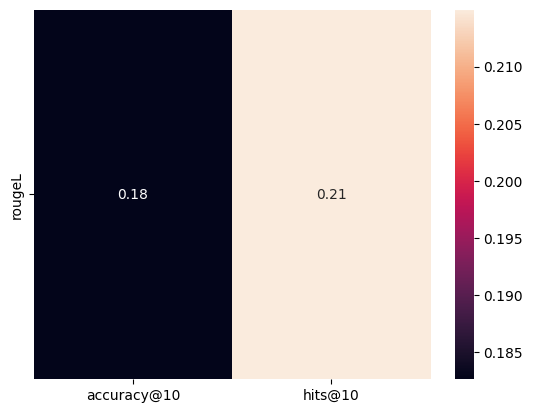

code2doc_reasoning sentence-transformers/all-mpnet-base-v2


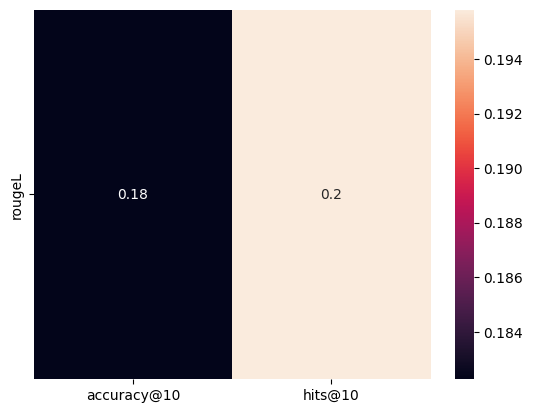

code2doc_reasoning sentence-transformers/all-MiniLM-L12-v2


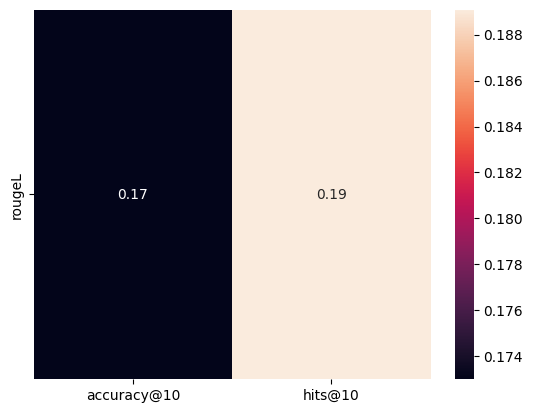

code2doc_generation_context bm25


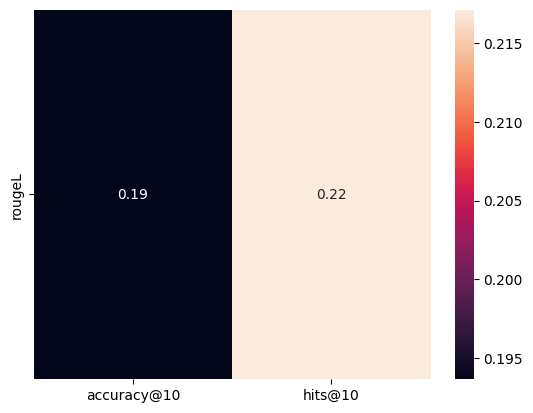

code2doc_generation_context sentence-transformers/all-mpnet-base-v2


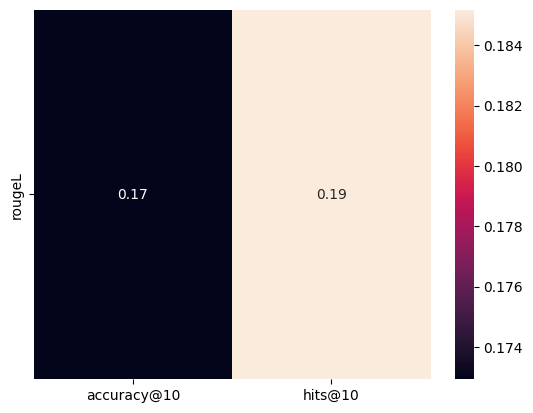

code2doc_generation_context sentence-transformers/all-MiniLM-L12-v2


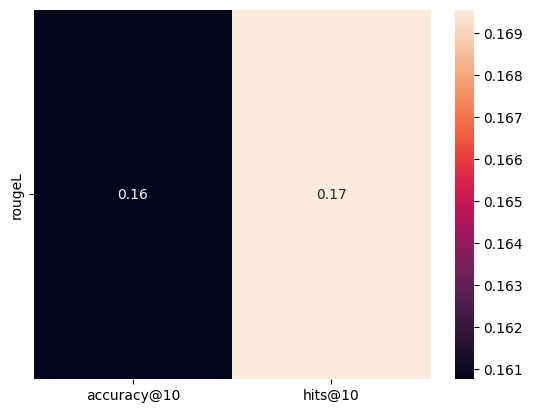

In [355]:
generation_vs_ir_kendall_dfs = []

for corpus_name in checked_corpora:
    for retriever_name in checked_retrievers:
        print(corpus_name, retriever_name)
        selected_metrics_df = per_query_metrics_df[
            (per_query_metrics_df["retriever"] == retriever_name) &
            (per_query_metrics_df["corpus"] == corpus_name)
        ][["query", "accuracy@10", "hits@10"]] 
        #worst_queries_df = per_query_generation_metrics_df.loc[worst_queries]
        corr_df = (
            selected_metrics_df
                .merge(per_query_generation_metrics_df, left_on="query", right_on="task")
                .select_dtypes("float")
                .corr(method="kendall").loc[shown_generation_metrics, ["accuracy@10", "hits@10"]]
        )
        sns.heatmap(corr_df, annot=True)
        plt.show()
        corr_df["retriever"] = [retriever_name]
        corr_df["corpus"] = [corpus_name]
        generation_vs_ir_kendall_dfs.append(corr_df[["corpus", "retriever", "accuracy@10", "hits@10"]])

generation_vs_ir_kendall_df = pd.concat(generation_vs_ir_kendall_dfs)

In [356]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.133080,0.131396
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.084386,0.084560
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.102777,0.099885
rougeL,repository_signature,bm25,0.153454,0.148897
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.098835,0.096088
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.104286,0.101287
rougeL,generated_tasks,bm25,0.157569,0.155984
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.113283,0.114696
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.148954,0.147906
rougeL,code2doc_generated_readme,bm25,0.185341,0.226952


In [358]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.133080,0.131396
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.084386,0.084560
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.102777,0.099885
rougeL,repository_signature,bm25,0.153454,0.148897
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.098835,0.096088
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.104286,0.101287
rougeL,generated_tasks,bm25,0.157569,0.155984
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.113283,0.114696
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.148954,0.147906
rougeL,code2doc_generated_readme,bm25,0.185341,0.226952


In [359]:
def corr_df_to_latex(generation_vs_ir_kendall_df):
    generation_vs_ir_kendall_df = generation_vs_ir_kendall_df.copy()
    #generation_vs_ir_kendall_df["corpus"] = generation_vs_ir_kendall_df["corpus"].apply(colorcodings)
    #generation_vs_ir_kendall_df["retriever"] = (
    #    generation_vs_ir_kendall_df["retriever"]
    #        .str.replace("sentence-transformers/all-mpnet-base-v2", "st-MPNet")
    #        .str.replace("sentence-transformers/all-MiniLM-L12-v2", "st-MiniLM")
    #)

    return (
        generation_vs_ir_kendall_df
            .sort_values("hits@10")
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.2f")
            .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
    )

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_638412/2538022487.py:14: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
/tmp/ipykernel_638412/2538022487.py:14: SyntaxWarning: invalid escape sequence '\h'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")


In [361]:
print(corr_df_to_latex(generation_vs_ir_kendall_df.drop(columns=["retriever"]).groupby("corpus").agg("mean").sort_values("hits@10").reset_index()))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & accuracy@10 & hits@10 \\
\hline
\midrule
\hline
dependency signature & 0.11 & 0.11 \\
\hline
repository signature & 0.12 & 0.12 \\
\hline
generated tasks & 0.14 & 0.14 \\
\hline
code2doc generation context & 0.18 & 0.19 \\
\hline
code2doc reasoning & 0.18 & 0.20 \\
\hline
code2doc generated readme & 0.19 & 0.21 \\
\hline
\bottomrule
\hline
\end{tabular}


In [362]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.133080,0.131396
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.084386,0.084560
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.102777,0.099885
rougeL,repository_signature,bm25,0.153454,0.148897
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.098835,0.096088
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.104286,0.101287
rougeL,generated_tasks,bm25,0.157569,0.155984
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.113283,0.114696
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.148954,0.147906
rougeL,code2doc_generated_readme,bm25,0.185341,0.226952


In [363]:
def get_metric_diffs(per_query_metrics_df, worst_queries):
    dfs = []
    for name, gp_df in per_query_metrics_df.groupby(["corpus", "retriever"]):
        selected_df = gp_df[gp_df["query"].isin(worst_queries)]
        selected_metrics_df = selected_df[["precision@10", "accuracy@10"]].mean()
        all_metrics_df = gp_df[["precision@10", "accuracy@10"]].mean()
        exp_difference_df = (all_metrics_df - selected_metrics_df)
        diffs = pd.concat([all_metrics_df, selected_metrics_df, exp_difference_df, 100 * (exp_difference_df / all_metrics_df)])
        diffs.index = ["precision@10", "accuracy@10", "worst records precision@10", "worst records accuracy@10", "precision@10 difference", "accuracy@10 difference", "% precision@10 difference", "% accuracy@10 difference"]
        diffs = pd.concat([pd.Series(dict(zip(["corpus", "retriever"], name))), diffs])
        dfs.append(diffs)
    return pd.concat(dfs, axis=1).T

In [364]:
def prettify_diffs_df(diff_df):
    for col in diff_df.columns:
        if "%" in col:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,1)).astype(str) + "%"
        else:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,3))
    return diff_df

In [365]:
diffs_df = get_metric_diffs(per_query_metrics_df, worst_queries)

In [366]:
aggregated_diffs_df = prettify_diffs_df(diffs_df.drop(columns="retriever").groupby("corpus").agg("mean").sort_values("% precision@10 difference", ascending=False))

In [367]:
per_query_metrics_df[].describe()[["precision@10", "accuracy@10"]]

SyntaxError: invalid syntax (4030047800.py, line 1)

In [368]:
per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)].describe()[["precision@10", "accuracy@10"]]

,precision@10,accuracy@10
count,1629.000000,1629.000000
mean,0.095703,0.372007
std,0.170506,0.483489
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.100000,1.000000
max,1.000000,1.000000


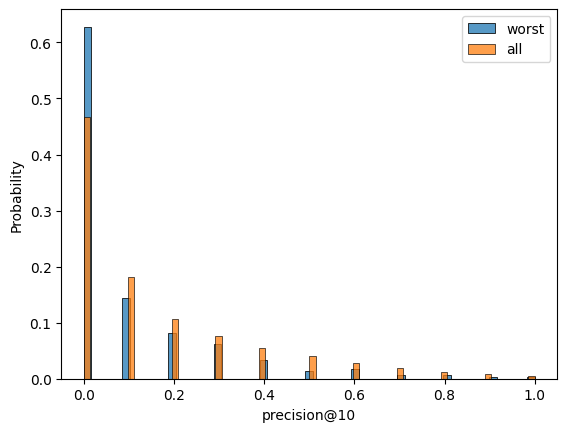

In [369]:
sns.histplot(per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]["precision@10"], kde=False, stat="probability", label="worst")
sns.histplot(per_query_metrics_df["precision@10"], kde=False, stat="probability", label="all")
plt.legend()
plt.savefig("/home/kuba/Downloads/worst_tasks_hits.png")

The following results show mean hits and accuracy@10 and the difference between these metrics for worst 10% queries as measured by generation metrics.

We investigate these differences further with Mann-Whitney test. The null hypothesis is $H_0: X_{worst} \not< X_{rest}$, that is, hits for the worst queries are not less than for the other queries. Assuming significance level of 0.01 we can refute $H_0$ for all corpora except original READMEs.

In [370]:



def make_displayed_agg_diffs_df(diffs_df, metric="accuracy"):
    displayed_df = aggregated_diffs_df[[col for col in aggregated_diffs_df.columns if metric in col]].copy()
    displayed_df[f"{metric}@10 difference"] = displayed_df[f"{metric}@10 difference"].apply(str) + " (" + displayed_df[f"% {metric}@10 difference"] + ")"
    displayed_df = displayed_df.drop("readme").reset_index()
    #displayed_df["corpus"] = displayed_df["corpus"].apply(colorcode)
    latex_str = (
        displayed_df
            .drop(columns=[f"% {metric}@10 difference"])
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.3f")
    )
    return latex_str.replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")

<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_638412/2131279001.py:11: SyntaxWarning: invalid escape sequence '\%'
  return latex_str.replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
/tmp/ipykernel_638412/2131279001.py:11: SyntaxWarning: invalid escape sequence '\h'
  return latex_str.replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")


In [374]:
aggregated_diffs_df

,precision@10,accuracy@10,worst records precision@10,worst records accuracy@10,precision@10 difference,accuracy@10 difference,% precision@10 difference,% accuracy@10 difference
corpus,,,,,,,,
generated_tasks,0.034,0.252,0.007,0.064,0.027,0.188,81.6%,76.8%
repository_signature,0.026,0.205,0.006,0.049,0.020,0.156,80.0%,78.4%
dependency_signature,0.019,0.151,0.006,0.044,0.013,0.106,69.3%,69.8%
selected_code,0.132,0.562,0.059,0.340,0.074,0.222,56.5%,41.1%
code2doc_generation_context,0.200,0.707,0.103,0.510,0.096,0.198,47.1%,29.0%
code2doc_generated_readme,0.260,0.785,0.149,0.586,0.111,0.199,44.1%,27.0%
code2doc_reasoning,0.248,0.769,0.138,0.593,0.110,0.176,43.9%,23.7%
readme,0.343,0.837,0.298,0.789,0.046,0.048,16.4%,8.2%


In [375]:
aggregated_diffs_df

,precision@10,accuracy@10,worst records precision@10,worst records accuracy@10,precision@10 difference,accuracy@10 difference,% precision@10 difference,% accuracy@10 difference
corpus,,,,,,,,
generated_tasks,0.034,0.252,0.007,0.064,0.027,0.188,81.6%,76.8%
repository_signature,0.026,0.205,0.006,0.049,0.020,0.156,80.0%,78.4%
dependency_signature,0.019,0.151,0.006,0.044,0.013,0.106,69.3%,69.8%
selected_code,0.132,0.562,0.059,0.340,0.074,0.222,56.5%,41.1%
code2doc_generation_context,0.200,0.707,0.103,0.510,0.096,0.198,47.1%,29.0%
code2doc_generated_readme,0.260,0.785,0.149,0.586,0.111,0.199,44.1%,27.0%
code2doc_reasoning,0.248,0.769,0.138,0.593,0.110,0.176,43.9%,23.7%
readme,0.343,0.837,0.298,0.789,0.046,0.048,16.4%,8.2%


In [376]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & accuracy@10 & worst records accuracy@10 & accuracy@10 difference \\
\hline
\midrule
\hline
generated tasks & 0.252 & 0.064 & 0.188 (76.8\%) \\
\hline
repository signature & 0.205 & 0.049 & 0.156 (78.4\%) \\
\hline
dependency signature & 0.151 & 0.044 & 0.106 (69.8\%) \\
\hline
selected code & 0.562 & 0.340 & 0.222 (41.1\%) \\
\hline
code2doc generation context & 0.707 & 0.510 & 0.198 (29.0\%) \\
\hline
code2doc generated readme & 0.785 & 0.586 & 0.199 (27.0\%) \\
\hline
code2doc reasoning & 0.769 & 0.593 & 0.176 (23.7\%) \\
\hline
\bottomrule
\hline
\end{tabular}


In [377]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df, "precision"))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & precision@10 & worst records precision@10 & precision@10 difference \\
\hline
\midrule
\hline
generated tasks & 0.034 & 0.007 & 0.027 (81.6\%) \\
\hline
repository signature & 0.026 & 0.006 & 0.02 (80.0\%) \\
\hline
dependency signature & 0.019 & 0.006 & 0.013 (69.3\%) \\
\hline
selected code & 0.132 & 0.059 & 0.074 (56.5\%) \\
\hline
code2doc generation context & 0.200 & 0.103 & 0.096 (47.1\%) \\
\hline
code2doc generated readme & 0.260 & 0.149 & 0.111 (44.1\%) \\
\hline
code2doc reasoning & 0.248 & 0.138 & 0.11 (43.9\%) \\
\hline
\bottomrule
\hline
\end{tabular}


In [378]:
from statsmodels.stats import weightstats
from statsmodels.stats.nonparametric import rank_compare_2indep
from scipy.stats import mannwhitneyu

In [379]:
worst_per_query_metrics_df = per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]

In [382]:
worst_comparison_records = []

for corpus in per_query_metrics_df["corpus"].unique():
    #for retriever in per_query_metrics_df["retriever"].unique():
    subset_df =  per_query_metrics_df[per_query_metrics_df["corpus"] == corpus]
    subset_df = subset_df.groupby(["query"]).apply(lambda df: df.select_dtypes("float").mean()).reset_index()
    #subset_df = subset_df[subset_df["retriever"] == retriever]
    res = mannwhitneyu(
        subset_df[subset_df["query"].isin(worst_queries)]["precision@10"].values,
        subset_df[~subset_df["query"].isin(worst_queries)]["precision@10"].values,
        alternative="less"
    )
    worst_comparison_records.append(dict(corpus=corpus, statistic=res.statistic, pvalue=res.pvalue))
    #print(res)

worst_comparison_df = pd.DataFrame(worst_comparison_records)

/tmp/ipykernel_638412/2700495135.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = subset_df.groupby(["query"]).apply(lambda df: df.select_dtypes("float").mean()).reset_index()
/tmp/ipykernel_638412/2700495135.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = subset_df.groupby(["query"]).apply(lambda df: df.select_dtypes("float").mean()).reset_index()
/tmp/ipykernel_638412/2700495135.py:6:

In [385]:
print(worst_comparison_df.sort_values("pvalue").to_latex(index=False, float_format="%.1e",column_format="|c|c|c|").strip().replace("\n", "\n\hline\n").replace("_", " "))

\begin{tabular}{|c|c|c|}
\hline
\toprule
\hline
corpus & statistic & pvalue \\
\hline
\midrule
\hline
selected code & 9.4e+03 & 1.2e-08 \\
\hline
code2doc generation context & 1.0e+04 & 5.0e-07 \\
\hline
code2doc reasoning & 1.1e+04 & 1.4e-06 \\
\hline
code2doc generated readme & 1.1e+04 & 2.7e-06 \\
\hline
repository signature & 1.3e+04 & 4.3e-05 \\
\hline
generated tasks & 1.3e+04 & 1.8e-04 \\
\hline
dependency signature & 1.4e+04 & 5.9e-04 \\
\hline
readme & 1.5e+04 & 1.9e-02 \\
\hline
\bottomrule
\hline
\end{tabular}


<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_638412/3885980332.py:1: SyntaxWarning: invalid escape sequence '\h'
  print(worst_comparison_df.sort_values("pvalue").to_latex(index=False, float_format="%.1e",column_format="|c|c|c|").strip().replace("\n", "\n\hline\n").replace("_", " "))
